## 3.3 实践：基于Softmax回归完成鸢尾花分类任务

在本节，我们用入门深度学习的基础实验之一“鸢尾花分类任务”来进行实践，使用经典学术数据集Iris作为训练数据，实现基于Softmax回归的鸢尾花分类任务。

实践流程主要包括以下7个步骤：数据处理、模型构建、损失函数定义、优化器构建、模型训练、模型评价和模型预测等，

* 数据处理：根据网络接收的数据格式，完成相应的预处理操作，保证模型正常读取；
* 模型构建：定义Softmax回归模型类；
* 训练配置：训练相关的一些配置，如：优化算法、评价指标等；
* 组装Runner类：Runner用于管理模型训练和测试过程；
* 模型训练和测试：利用Runner进行模型训练、评价和测试。

****
**说明：**

使用深度学习进行实践时的操作流程基本一致，后文不再赘述。

****

本实践的主要配置如下：

* 数据：Iris数据集；
* 模型：Softmax回归模型；
* 损失函数：交叉熵损失；
* 优化器：梯度下降法；
* 评价指标：准确率。

### 3.3.1 数据处理

#### 3.3.1.1 数据集介绍

Iris数据集，也称为鸢尾花数据集，包含了3种鸢尾花类别（Setosa、Versicolour、Virginica），每种类别有50个样本，共计150个样本。其中每个样本中包含了4个属性：花萼长度、花萼宽度、花瓣长度以及花瓣宽度，本实验通过鸢尾花这4个属性来判断该样本的类别。


**鸢尾花属性**
<center>
  
|属性1   |属性2   |属性3    |属性4    |
|:--:    |:--:   |:--:    |:--:     |
|sepal_length |sepal_width|petal_length|petal_width|
|花萼长度      |花萼宽度|花瓣长度|花瓣宽度|
</center>


**鸢尾花类别**
<center>
  
|英文名            |中文名      |标签    |
|:--:             |:--:        |:--:    |
|Setosa Iris      |狗尾草鸢尾   |  0
|Versicolour Iris |杂色鸢尾     |  1
|Virginica Iris   |弗吉尼亚鸢尾  |  2
  
</center>

**鸢尾花属性类别对应预览**

<center>
  
|sepal_length |sepal_width|petal_length|petal_width| species 
|:--:         |:--:       |:--:        |:--:       |:--:       |
|5.1	      |3.5	      |1.4	       |0.2	       |setosa
|4.9	      |3	      |1.4	       |0.2	       |setosa
|4.7	      |3.2	      |1.3	       |0.2	       |setosa
|...          |...        |...         |...        |...        |

</center>


#### 3.3.1.2 数据清洗

* **缺失值分析**

对数据集中的缺失值或异常值等情况进行分析和处理，保证数据可以被模型正常读取。代码实现如下：

In [1]:
from sklearn.datasets import load_iris
import pandas
import numpy as np

iris_features = np.array(load_iris().data, dtype=np.float32)
iris_labels = np.array(load_iris().target, dtype=np.int32)
print(pandas.isna(iris_features).sum())
print(pandas.isna(iris_labels).sum())

0
0


从输出结果看，鸢尾花数据集中不存在缺失值的情况。

* **异常值处理**

通过箱线图直观的显示数据分布，并观测数据中的异常值。

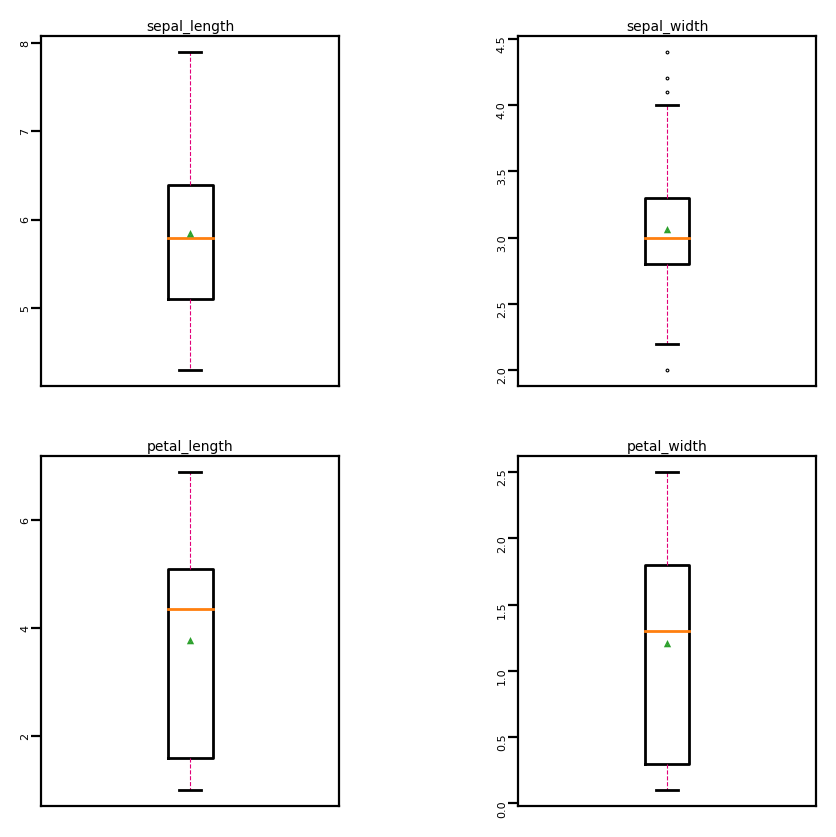

In [2]:
import matplotlib.pyplot as plt #可视化工具

# 箱线图查看异常值分布
def boxplot(features):
    feature_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

    # 连续画几个图片
    plt.figure(figsize=(5, 5), dpi=200)
    # 子图调整
    plt.subplots_adjust(wspace=0.6)
    # 每个特征画一个箱线图
    for i in range(4):
        plt.subplot(2, 2, i+1)
        # 画箱线图
        plt.boxplot(features[:, i], 
                    showmeans=True, 
                    whiskerprops={"color":"#E20079", "linewidth":0.4, 'linestyle':"--"},
                    flierprops={"markersize":0.4},
                    meanprops={"markersize":1})
        # 图名
        plt.title(feature_names[i], fontdict={"size":5}, pad=2)
        # y方向刻度
        plt.yticks(fontsize=4, rotation=90)
        plt.tick_params(pad=0.5)
        # x方向刻度
        plt.xticks([])
    plt.savefig('ml-vis.pdf')
    plt.show()

boxplot(iris_features)

从输出结果看，数据中基本不存在异常值，所以不需要进行异常值处理。

#### 3.3.1.3 数据读取

本实验中将数据集划分为了三个部分：

* 训练集：用于确定模型参数；
* 验证集：与训练集独立的样本集合，用于使用提前停止策略选择最优模型；
* 测试集：用于估计应用效果（没有在模型中应用过的数据，更贴近模型在真实场景应用的效果）。

在本实验中，将$80\%$的数据用于模型训练，$10\%$的数据用于模型验证，$10\%$的数据用于模型测试。代码实现如下：

In [3]:
import copy
import paddle 

# 加载数据集
def load_data(shuffle=True):
    """
    加载鸢尾花数据
    输入：
        - shuffle：是否打乱数据，数据类型为bool
    输出：
        - X：特征数据，shape=[150,4]
        - y：标签数据, shape=[150]
    """
    # 加载原始数据
    X = np.array(load_iris().data, dtype=np.float32)
    y = np.array(load_iris().target, dtype=np.int32)

    X = paddle.to_tensor(X)
    y = paddle.to_tensor(y)

    # 数据归一化
    X_min = paddle.min(X, axis=0)
    X_max = paddle.max(X, axis=0)
    X = (X-X_min) / (X_max-X_min)

    # 如果shuffle为True，随机打乱数据
    if shuffle:
        idx = paddle.randperm(X.shape[0])
        X = X[idx]
        y = y[idx]
    return X, y

# 固定随机种子
paddle.seed(102)

num_train = 120
num_dev = 15
num_test = 15

X, y = load_data(shuffle=True)
print("X shape: ", X.shape, "y shape: ", y.shape)
X_train, y_train = X[:num_train], y[:num_train]
X_dev, y_dev = X[num_train:num_train + num_dev], y[num_train:num_train + num_dev]
X_test, y_test = X[num_train + num_dev:], y[num_train + num_dev:]

X shape:  [150, 4] y shape:  [150]


In [4]:
# 打印X_train和y_train的维度
print("X_train shape: ", X_train.shape, "y_train shape: ", y_train.shape)

X_train shape:  [120, 4] y_train shape:  [120]


In [5]:
# 打印前5个数据的标签
print(y_train[:5])

Tensor(shape=[5], dtype=int32, place=Place(gpu:0), stop_gradient=True,
       [2, 0, 0, 0, 1])


### 3.3.2 模型构建

使用Softmax回归模型进行鸢尾花分类实验，将模型的输入维度定义为4，输出维度定义为3。代码实现如下：

In [6]:
from nndl import op

# 输入维度
input_dim = 4
# 类别数
output_dim = 3
# 实例化模型
model = op.model_SR(input_dim=input_dim, output_dim=output_dim)

### 3.3.3 模型训练

实例化RunnerV2类，使用训练集和验证集进行模型训练，共训练80个epoch，其中每隔10个epoch打印训练集上的指标，并且保存准确率最高的模型作为最佳模型。代码实现如下：

In [7]:
from nndl import op, metric, opitimizer, RunnerV2

# 学习率
lr = 0.2

# 梯度下降法
optimizer = opitimizer.SimpleBatchGD(init_lr=lr, model=model)
# 交叉熵损失
loss_fn = op.MultiCrossEntropyLoss()
# 准确率
metric = metric.accuracy

# 实例化RunnerV2
runner = RunnerV2(model, optimizer, metric, loss_fn)

# 启动训练
runner.train([X_train, y_train], [X_dev, y_dev], num_epochs=200, log_epochs=10, save_path="best_model.pdparams")

best accuracy performence has been updated: 0.00000 --> 0.33333
[Train] epoch: 0, loss: 1.09861159324646, score: 0.3500000238418579
[Dev] epoch: 0, loss: 1.0872310400009155, score: 0.3333333432674408
best accuracy performence has been updated: 0.33333 --> 0.40000
best accuracy performence has been updated: 0.40000 --> 0.46667
best accuracy performence has been updated: 0.46667 --> 0.60000
[Train] epoch: 10, loss: 0.9777340292930603, score: 0.7000000476837158
[Dev] epoch: 10, loss: 0.998892605304718, score: 0.6000000238418579
[Train] epoch: 20, loss: 0.8945356011390686, score: 0.7000000476837158
[Dev] epoch: 20, loss: 0.9269810318946838, score: 0.6000000238418579
[Train] epoch: 30, loss: 0.8285729289054871, score: 0.7000000476837158
[Dev] epoch: 30, loss: 0.8667001128196716, score: 0.6000000238418579
[Train] epoch: 40, loss: 0.7752518653869629, score: 0.7000000476837158
[Dev] epoch: 40, loss: 0.8166458606719971, score: 0.6000000238418579
[Train] epoch: 50, loss: 0.7315736413002014, scor

可视化观察训练集与验证集的准确率变化情况。

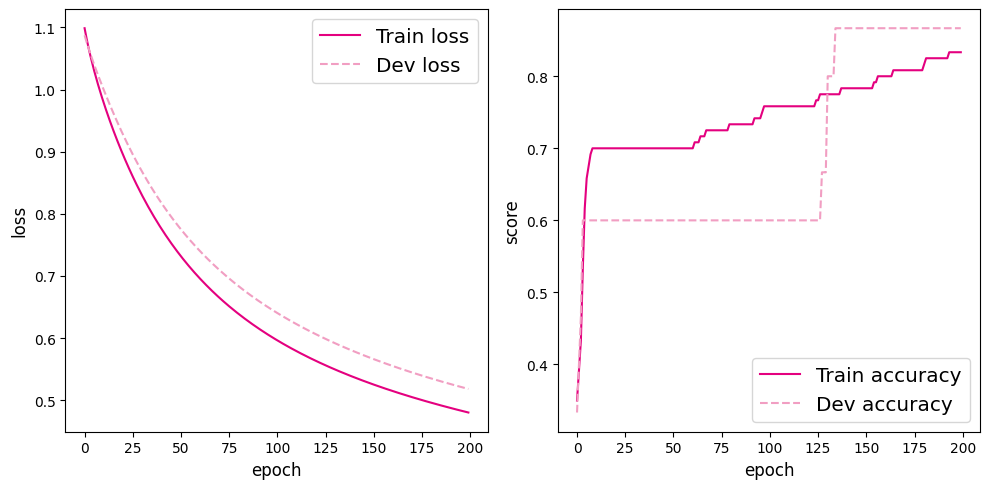

In [8]:
from nndl import plot

plot(runner, fig_name='linear-acc3.pdf')

### 3.3.4 模型评价

使用测试数据对在训练过程中保存的最佳模型进行评价，观察模型在测试集上的准确率情况。代码实现如下：

In [9]:
# 加载最优模型
runner.load_model('best_model.pdparams')
# 模型评价
score, loss = runner.evaluate([X_test, y_test])
print("[Test] score/loss: {:.4f}/{:.4f}".format(score, loss))

[Test] score/loss: 0.6667/0.6573


### 3.3.5 模型预测

使用保存好的模型，对测试集中的数据进行模型预测，并取出1条数据观察模型效果。代码实现如下：

In [10]:
# 预测测试集数据
logits = runner.predict(X_test)
# 观察其中一条样本的预测结果
pred = paddle.argmax(logits[0]).numpy()
# 获取该样本概率最大的类别
label = y_test[0].numpy()
# 输出真实类别与预测类别
print("The true category is {} and the predicted category is {}".format(label[0], pred[0]))

The true category is 1 and the predicted category is 2


## 3.4 小结

本节实现了Logistic回归和Softmax回归两种基本的线性分类模型。

## 3.5 实验拓展

为了加深对机器学习模型的理解，请自己动手完成以下实验：

1. 尝试调整学习率和训练轮数等超参数，观察是否能够得到更高的精度；
1. 在解决多分类问题时，还有一个思路是将每个类别的求解问题拆分成一个二分类任务，通过判断是否属于该类别来判断最终结果。请分别尝试两种求解思路，观察哪种能够取得更好的结果；
1. 尝试使用《神经网络与深度学习》中的其他模型进行鸢尾花识别任务，观察是否能够得到更高的精度。